# Algorithm Comparison: OPTICS vs KMeans vs DBSCAN

Side-by-side comparison of all three clustering algorithms run on the same
40-ticker semiconductor universe with identical feature engineering.
Loads only saved pickle artifacts — no data re-fetching.

In [1]:
# ==========================================================================
# SECTION 1: Setup & Load Artifacts
# ==========================================================================
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data')

# Algorithm definitions: (label, artifact prefix)
ALGO_DEFS = [
    ('OPTICS',  ''),
    ('KMeans',  'kmeans_'),
    ('DBSCAN',  'dbscan_'),
]

ARTIFACT_NAMES = [
    'ts_df', 'cluster_history', 'df_pair_stability',
    'pair_co_cluster_freq', 'df_formations', 'df_formations_actionable',
    'df_durations', 'pair_classification', 'oos_split_timestamp',
]

# Color scheme
COLORS = {'OPTICS': '#2ca02c', 'KMeans': '#1f77b4', 'DBSCAN': '#d62728'}

# Load artifacts
data = {}  # data[algo_label][artifact_name]
available_algos = []

for label, prefix in ALGO_DEFS:
    algo_data = {}
    missing = []
    for name in ARTIFACT_NAMES:
        path = os.path.join(DATA_DIR, f'{prefix}{name}.pkl')
        if os.path.exists(path):
            with open(path, 'rb') as f:
                algo_data[name] = pickle.load(f)
        else:
            missing.append(name)
    if missing:
        print(f'WARNING: {label} missing artifacts: {missing}')
    if 'cluster_history' in algo_data:
        data[label] = algo_data
        available_algos.append(label)
        print(f'{label}: loaded {len(algo_data)}/{len(ARTIFACT_NAMES)} artifacts')
    else:
        print(f'{label}: SKIPPED (no cluster_history)')

# Clip all cluster histories to a common time range
if len(available_algos) > 1:
    earliest_start = max(data[algo]['cluster_history']['Datetime'].min() for algo in available_algos)
    latest_end = min(data[algo]['cluster_history']['Datetime'].max() for algo in available_algos)
    print(f'\nClipping all algorithms to common time range:')
    print(f'  Start: {earliest_start}')
    print(f'  End:   {latest_end}')

    for algo in available_algos:
        ch = data[algo]['cluster_history']
        before = len(ch)
        data[algo]['cluster_history'] = ch[(ch['Datetime'] >= earliest_start) & (ch['Datetime'] <= latest_end)]
        after = len(data[algo]['cluster_history'])
        print(f'  {algo}: {before} -> {after} rows ({before - after} clipped)')

print(f'\nAlgorithms available: {available_algos}')

OPTICS: loaded 9/9 artifacts
KMeans: loaded 9/9 artifacts
DBSCAN: loaded 9/9 artifacts

Clipping all algorithms to common time range:
  Start: 2025-03-24 16:30:00+00:00
  End:   2026-02-23 20:30:00+00:00
  OPTICS: 54547 -> 54547 rows (0 clipped)
  KMeans: 63152 -> 63112 rows (40 clipped)
  DBSCAN: 63152 -> 63112 rows (40 clipped)

Algorithms available: ['OPTICS', 'KMeans', 'DBSCAN']


# 2. Clustering Quality

In [2]:
# ==========================================================================
# SECTION 2: Clustering Quality Comparison
# ==========================================================================
print('='*80)
print('CLUSTERING QUALITY COMPARISON')
print('='*80)

quality_rows = []
for algo in available_algos:
    ch = data[algo]['cluster_history']
    ts_count = ch['Datetime'].nunique()
    total_rows = len(ch)
    
    # Clusters per timestamp
    clusters_per_ts = ch.groupby('Datetime').apply(
        lambda g: len(set(g['Cluster_ID'])) - (1 if -1 in g['Cluster_ID'].values else 0)
    )
    
    # Noise rate per timestamp
    noise_per_ts = ch.groupby('Datetime').apply(
        lambda g: (g['Cluster_ID'] == -1).mean()
    )
    
    # Stocks per timestamp
    stocks_per_ts = ch.groupby('Datetime')['Ticker'].nunique()
    
    quality_rows.append({
        'Algorithm': algo,
        'Valid Windows': ts_count,
        'Avg Clusters/ts': clusters_per_ts.mean(),
        'Std Clusters/ts': clusters_per_ts.std(),
        'Avg Noise %': noise_per_ts.mean() * 100,
        'Avg Stocks/ts': stocks_per_ts.mean(),
        'Total Rows': total_rows,
    })

df_quality = pd.DataFrame(quality_rows).set_index('Algorithm')
print(df_quality.round(2).to_string())
print()

CLUSTERING QUALITY COMPARISON


           Valid Windows  Avg Clusters/ts  Std Clusters/ts  Avg Noise %  Avg Stocks/ts  Total Rows
Algorithm                                                                                         
OPTICS              1364             3.36             1.01        58.46          39.99       54547
KMeans              1578             3.09             1.99        10.00          39.99       63112
DBSCAN              1578             1.47             0.62        28.00          39.99       63112



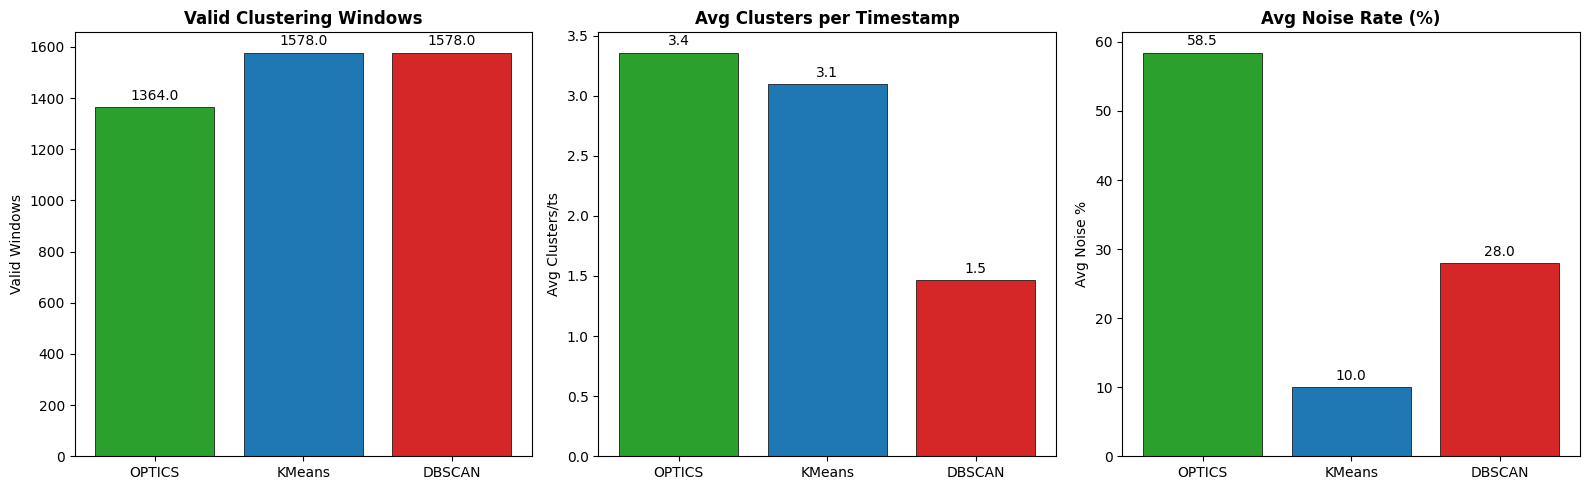

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar chart: valid windows, avg clusters, avg noise
metrics = ['Valid Windows', 'Avg Clusters/ts', 'Avg Noise %']
titles = ['Valid Clustering Windows', 'Avg Clusters per Timestamp', 'Avg Noise Rate (%)']

for ax, metric, title in zip(axes, metrics, titles):
    vals = [df_quality.loc[a, metric] for a in available_algos]
    colors = [COLORS[a] for a in available_algos]
    bars = ax.bar(available_algos, vals, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01 * max(vals),
                f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

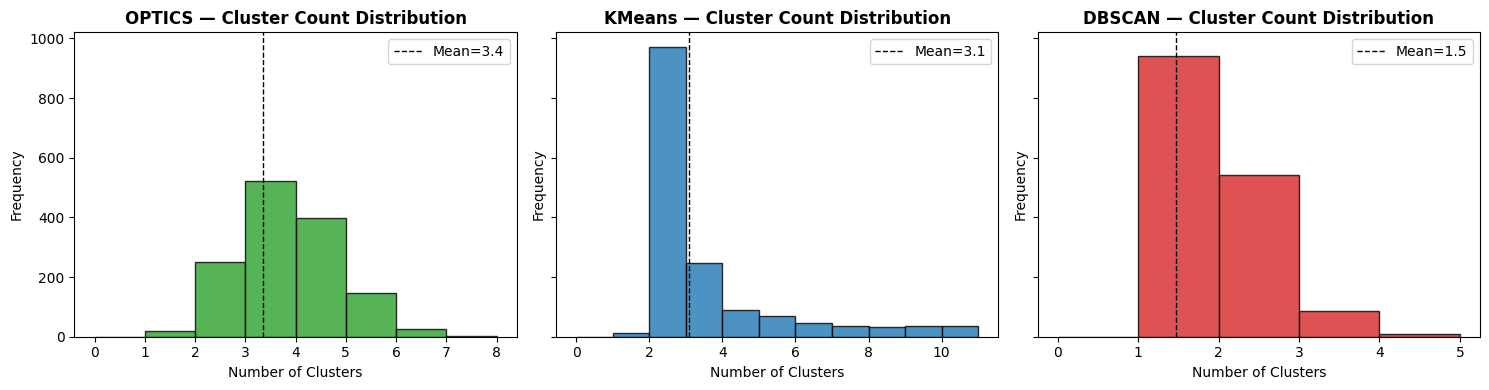

In [4]:
# Cluster count distribution histograms
fig, axes = plt.subplots(1, len(available_algos), figsize=(5 * len(available_algos), 4),
                         sharey=True)
if len(available_algos) == 1:
    axes = [axes]

for ax, algo in zip(axes, available_algos):
    ch = data[algo]['cluster_history']
    clusters_per_ts = ch.groupby('Datetime').apply(
        lambda g: len(set(g['Cluster_ID'])) - (1 if -1 in g['Cluster_ID'].values else 0)
    )
    ax.hist(clusters_per_ts, bins=range(0, int(clusters_per_ts.max()) + 2),
            color=COLORS[algo], edgecolor='black', alpha=0.8)
    ax.set_title(f'{algo} — Cluster Count Distribution', fontweight='bold')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Frequency')
    ax.axvline(clusters_per_ts.mean(), color='black', linestyle='--', linewidth=1,
               label=f'Mean={clusters_per_ts.mean():.1f}')
    ax.legend()

plt.tight_layout()
plt.show()

# 3. Pair Discovery Overlap

In [5]:
# ==========================================================================
# SECTION 3: Pair Discovery Overlap
# ==========================================================================
print('='*80)
print('PAIR DISCOVERY OVERLAP')
print('='*80)

# Top-20 pairs per algorithm
top_n = 20
top_pairs = {}
for algo in available_algos:
    stab = data[algo]['df_pair_stability']
    top_pairs[algo] = set(stab.nlargest(top_n, 'Co_Cluster_Frequency')['Pair'].tolist())

# Pairwise and 3-way intersection
print(f'\nTop-{top_n} Pair Overlap:')
for a1, a2 in combinations(available_algos, 2):
    overlap = top_pairs[a1] & top_pairs[a2]
    print(f'  {a1} & {a2}: {len(overlap)} pairs in common')

if len(available_algos) == 3:
    three_way = top_pairs[available_algos[0]] & top_pairs[available_algos[1]] & top_pairs[available_algos[2]]
    print(f'  All three: {len(three_way)} consensus pairs')
    if three_way:
        print(f'  Consensus pairs: {sorted(three_way)}')

# Union of top-15 for frequency comparison table
top_15_union = set()
for algo in available_algos:
    stab = data[algo]['df_pair_stability']
    top_15_union |= set(stab.nlargest(15, 'Co_Cluster_Frequency')['Pair'].tolist())

freq_comparison = []
for pair in sorted(top_15_union):
    row = {'Pair': pair}
    for algo in available_algos:
        stab = data[algo]['df_pair_stability']
        match = stab[stab['Pair'] == pair]
        row[algo] = match['Co_Cluster_Frequency'].values[0] if len(match) > 0 else 0.0
    freq_comparison.append(row)

df_freq_comp = pd.DataFrame(freq_comparison).set_index('Pair').sort_values(
    available_algos[0], ascending=False)

print(f'\nCo-Cluster Frequency for Union of Top-15 Pairs ({len(df_freq_comp)} pairs):')
print(df_freq_comp.round(3).to_string())

PAIR DISCOVERY OVERLAP

Top-20 Pair Overlap:
  OPTICS & KMeans: 13 pairs in common
  OPTICS & DBSCAN: 9 pairs in common
  KMeans & DBSCAN: 12 pairs in common
  All three: 8 consensus pairs
  Consensus pairs: ['ADI-NXPI', 'ADI-SWKS', 'ADI-TXN', 'AMAT-KLAC', 'AMAT-LRCX', 'KLAC-LRCX', 'NXPI-TXN', 'QRVO-SWKS']

Co-Cluster Frequency for Union of Top-15 Pairs (26 pairs):
           OPTICS  KMeans  DBSCAN
Pair                             
QRVO-SWKS   0.383   0.835   0.826
KLAC-LRCX   0.364   0.774   0.846
AMAT-LRCX   0.361   0.785   0.841
AMAT-KLAC   0.326   0.771   0.806
ADI-NXPI    0.262   0.801   0.897
ADI-TXN     0.257   0.815   0.815
MCHP-NXPI   0.232   0.743   0.755
QCOM-QRVO   0.227   0.740   0.719
ADI-SWKS    0.222   0.794   0.828
QCOM-SWKS   0.214   0.770   0.767
NXPI-STM    0.207   0.752   0.782
NXPI-TXN    0.203   0.759   0.807
MCHP-ON     0.202   0.716   0.641
CDNS-SNPS   0.196   0.726   0.631
ADI-QCOM    0.196   0.719   0.745
LRCX-TSM    0.172   0.687   0.849
GFS-NXPI    0.153   

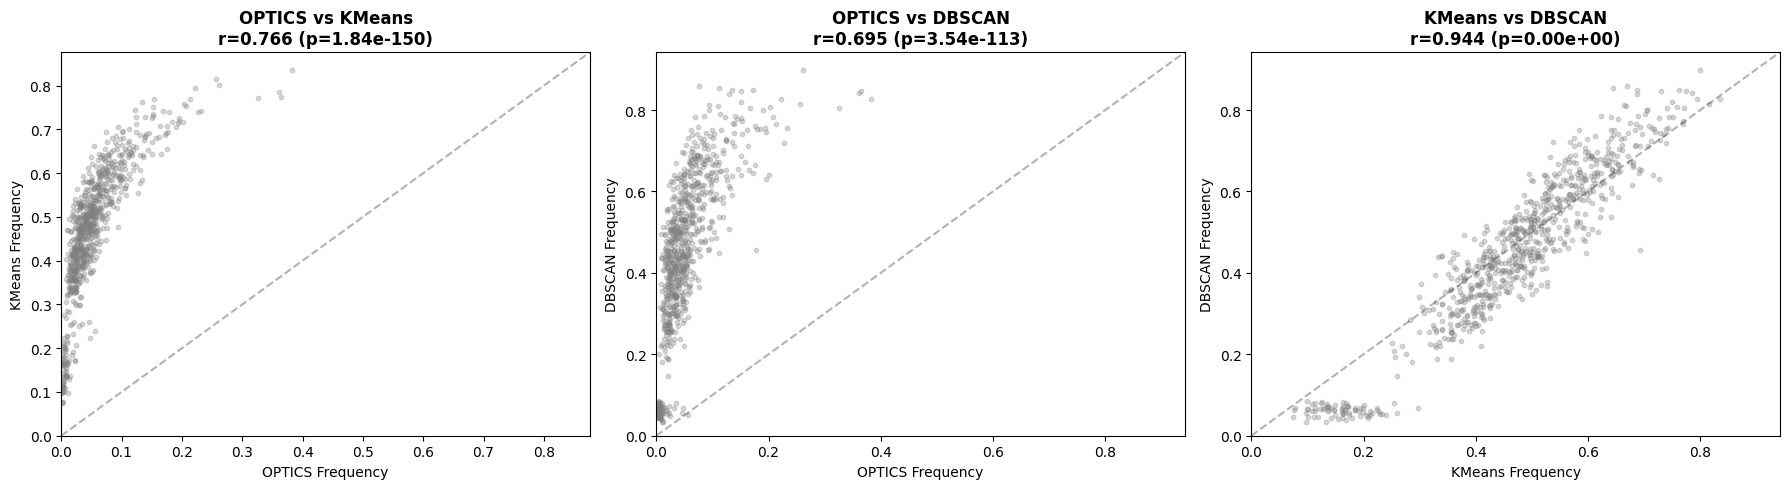

In [6]:
# Scatter plots of frequency correlation between algorithm pairs
algo_combos = list(combinations(available_algos, 2))
n_combos = len(algo_combos)

fig, axes = plt.subplots(1, max(n_combos, 1), figsize=(6 * max(n_combos, 1), 5))
if n_combos == 1:
    axes = [axes]

for ax, (a1, a2) in zip(axes, algo_combos):
    # Get all pairs present in both
    stab1 = data[a1]['df_pair_stability'].set_index('Pair')['Co_Cluster_Frequency']
    stab2 = data[a2]['df_pair_stability'].set_index('Pair')['Co_Cluster_Frequency']
    common = stab1.index.intersection(stab2.index)
    if len(common) > 0:
        v1 = stab1.loc[common].values
        v2 = stab2.loc[common].values
        r, p = pearsonr(v1, v2)
        ax.scatter(v1, v2, alpha=0.3, s=10, color='gray')
        ax.set_xlabel(f'{a1} Frequency')
        ax.set_ylabel(f'{a2} Frequency')
        ax.set_title(f'{a1} vs {a2}\nr={r:.3f} (p={p:.2e})', fontweight='bold')
        # 45-degree line
        lim = max(v1.max(), v2.max()) * 1.05
        ax.plot([0, lim], [0, lim], 'k--', alpha=0.3)
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)

plt.tight_layout()
plt.show()

# 4. Formation & Duration Dynamics

In [7]:
# ==========================================================================
# SECTION 4: Formation & Duration Dynamics
# ==========================================================================
print('='*80)
print('FORMATION & DURATION DYNAMICS')
print('='*80)

formation_rows = []
for algo in available_algos:
    fm = data[algo].get('df_formations', pd.DataFrame())
    fa = data[algo].get('df_formations_actionable', pd.DataFrame())
    dur = data[algo].get('df_durations', pd.DataFrame())
    
    row = {
        'Algorithm': algo,
        'Total Formations': len(fm),
        'Actionable Formations': len(fa),
        'Actionable Rate': len(fa) / max(len(fm), 1),
        'Unique Pairs w/ Formations': fm['Pair'].nunique() if len(fm) > 0 else 0,
    }
    if len(dur) > 0:
        row['Mean Duration (h)'] = dur['Duration_Hours'].mean()
        row['Median Duration (h)'] = dur['Duration_Hours'].median()
        row['Max Duration (h)'] = dur['Duration_Hours'].max()
    formation_rows.append(row)

df_formations_comp = pd.DataFrame(formation_rows).set_index('Algorithm')
print(df_formations_comp.round(2).to_string())

FORMATION & DURATION DYNAMICS
           Total Formations  Actionable Formations  Actionable Rate  Unique Pairs w/ Formations  Mean Duration (h)  Median Duration (h)  Max Duration (h)
Algorithm                                                                                                                                                
OPTICS                20242                  20242             1.00                         776              19.86                  1.0            1178.0
KMeans                28136                  18829             0.67                         780              25.39                  9.0             705.0
DBSCAN                27663                  17507             0.63                         780              26.42                  9.0             963.0


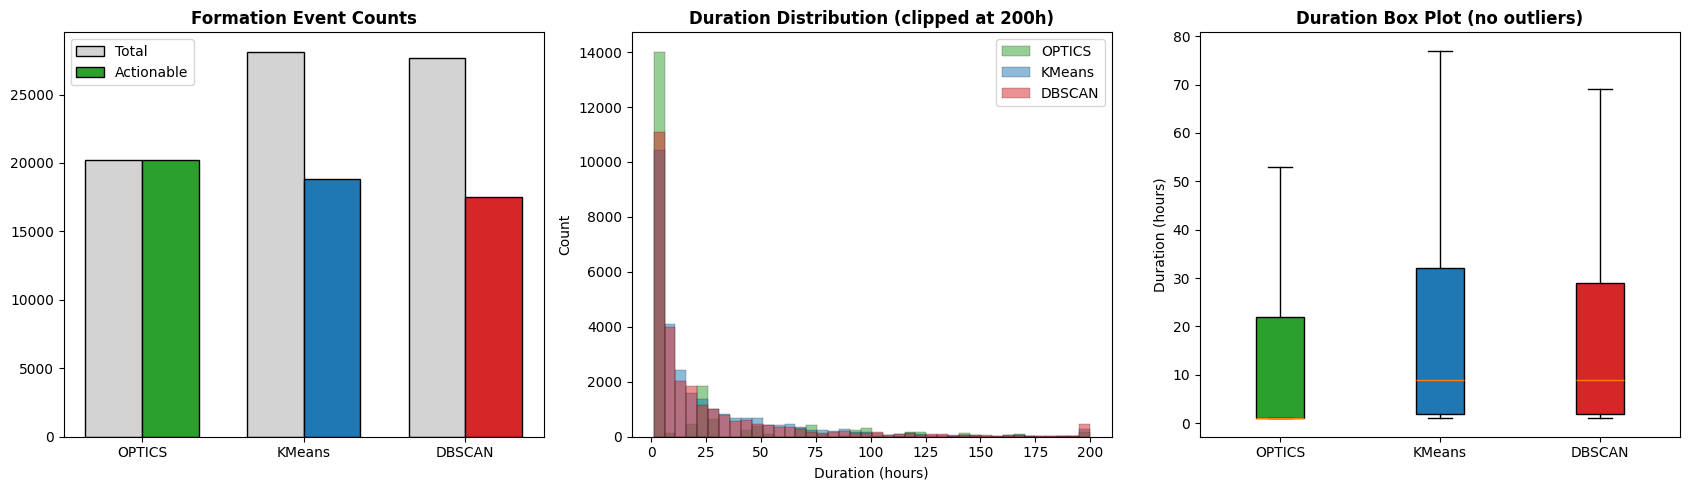

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Bar: formation counts
ax = axes[0]
x = np.arange(len(available_algos))
w = 0.35
total_vals = [df_formations_comp.loc[a, 'Total Formations'] for a in available_algos]
action_vals = [df_formations_comp.loc[a, 'Actionable Formations'] for a in available_algos]
ax.bar(x - w/2, total_vals, w, label='Total', color='lightgray', edgecolor='black')
ax.bar(x + w/2, action_vals, w, label='Actionable',
       color=[COLORS[a] for a in available_algos], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(available_algos)
ax.set_title('Formation Event Counts', fontweight='bold')
ax.legend()

# Duration histogram overlay
ax = axes[1]
for algo in available_algos:
    dur = data[algo].get('df_durations', pd.DataFrame())
    if len(dur) > 0:
        ax.hist(dur['Duration_Hours'].clip(upper=200), bins=40, alpha=0.5,
                color=COLORS[algo], label=algo, edgecolor='black', linewidth=0.3)
ax.set_title('Duration Distribution (clipped at 200h)', fontweight='bold')
ax.set_xlabel('Duration (hours)')
ax.set_ylabel('Count')
ax.legend()

# Box plot of durations
ax = axes[2]
dur_data = []
dur_labels = []
for algo in available_algos:
    dur = data[algo].get('df_durations', pd.DataFrame())
    if len(dur) > 0:
        dur_data.append(dur['Duration_Hours'].clip(upper=300).values)
        dur_labels.append(algo)
bp = ax.boxplot(dur_data, labels=dur_labels, patch_artist=True, showfliers=False)
for patch, algo in zip(bp['boxes'], dur_labels):
    patch.set_facecolor(COLORS[algo])
ax.set_title('Duration Box Plot (no outliers)', fontweight='bold')
ax.set_ylabel('Duration (hours)')

plt.tight_layout()
plt.show()

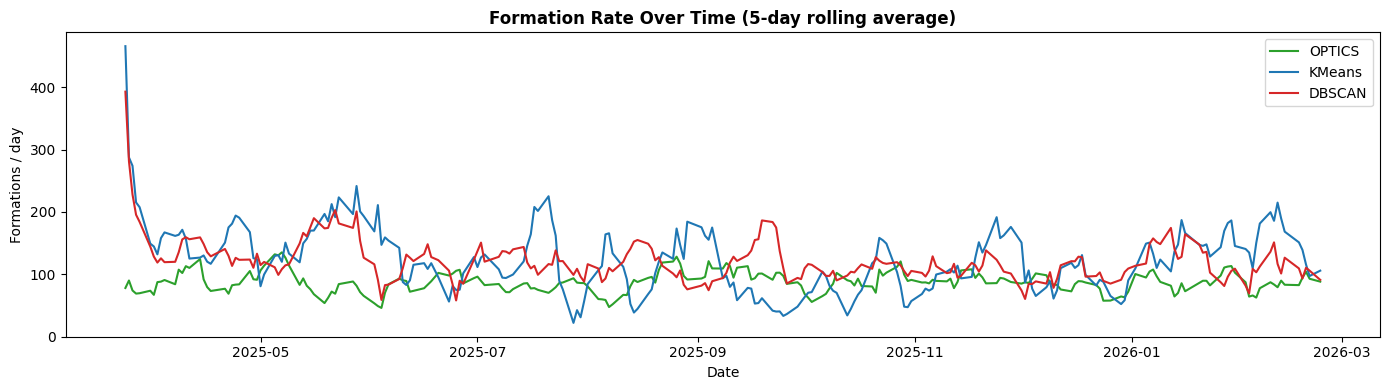

In [9]:
# Formation rate over time
fig, ax = plt.subplots(figsize=(14, 4))

for algo in available_algos:
    fm = data[algo].get('df_formations', pd.DataFrame())
    if len(fm) > 0 and 'Formation_Time' in fm.columns:
        fm_ts = pd.to_datetime(fm['Formation_Time'])
        daily = fm_ts.dt.date.value_counts().sort_index()
        daily_s = pd.Series(daily.values, index=pd.to_datetime(daily.index))
        rolling = daily_s.rolling(5, min_periods=1).mean()
        ax.plot(rolling.index, rolling.values, color=COLORS[algo], label=algo, linewidth=1.5)

ax.set_title('Formation Rate Over Time (5-day rolling average)', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Formations / day')
ax.legend()
plt.tight_layout()
plt.show()

# 5. Pair Classification

In [10]:
# ==========================================================================
# SECTION 5: Pair Classification Comparison
# ==========================================================================
print('='*80)
print('PAIR CLASSIFICATION')
print('='*80)

categories = ['transient', 'stable_candidate', 'sporadic', 'unknown']
cat_counts = {}

for algo in available_algos:
    pc = data[algo].get('pair_classification', pd.DataFrame())
    if len(pc) > 0:
        counts = pc['Category'].value_counts()
        cat_counts[algo] = {cat: counts.get(cat, 0) for cat in categories}
        print(f'\n{algo}:')
        for cat in categories:
            n = cat_counts[algo][cat]
            print(f'  {cat:20s}: {n:4d} ({n/len(pc):.1%})')

# Transient pair overlap
print(f'\n{"-"*60}')
print('Transient Pair Overlap:')
transient_sets = {}
for algo in available_algos:
    pc = data[algo].get('pair_classification', pd.DataFrame())
    if len(pc) > 0:
        transient_sets[algo] = set(pc[pc['Category'] == 'transient']['Pair'].tolist())
        print(f'  {algo}: {len(transient_sets[algo])} transient pairs')

for a1, a2 in combinations(available_algos, 2):
    if a1 in transient_sets and a2 in transient_sets:
        overlap = transient_sets[a1] & transient_sets[a2]
        print(f'  {a1} & {a2}: {len(overlap)} overlap')

if len(available_algos) == 3:
    all_trans = set.intersection(*[transient_sets[a] for a in available_algos if a in transient_sets])
    print(f'  All three: {len(all_trans)} consensus transient pairs')
    if all_trans:
        print(f'  Consensus: {sorted(all_trans)}')

PAIR CLASSIFICATION

OPTICS:
  transient           :  681 (87.8%)
  stable_candidate    :    6 (0.8%)
  sporadic            :   11 (1.4%)
  unknown             :   78 (10.1%)

KMeans:
  transient           :  549 (70.4%)
  stable_candidate    :  231 (29.6%)
  sporadic            :    0 (0.0%)
  unknown             :    0 (0.0%)

DBSCAN:
  transient           :  474 (60.8%)
  stable_candidate    :  306 (39.2%)
  sporadic            :    0 (0.0%)
  unknown             :    0 (0.0%)

------------------------------------------------------------
Transient Pair Overlap:
  OPTICS: 681 transient pairs
  KMeans: 549 transient pairs
  DBSCAN: 474 transient pairs
  OPTICS & KMeans: 519 overlap
  OPTICS & DBSCAN: 448 overlap
  KMeans & DBSCAN: 446 overlap
  All three: 424 consensus transient pairs
  Consensus: ['ADI-ALAB', 'ADI-AMD', 'ADI-CAMT', 'ADI-INTC', 'ADI-MRVL', 'ADI-SMTC', 'ADI-STX', 'ADI-TOELY', 'ADI-VICR', 'ALAB-AMAT', 'ALAB-AMD', 'ALAB-ARM', 'ALAB-ASML', 'ALAB-AVGO', 'ALAB-CAMT', 'ALAB-

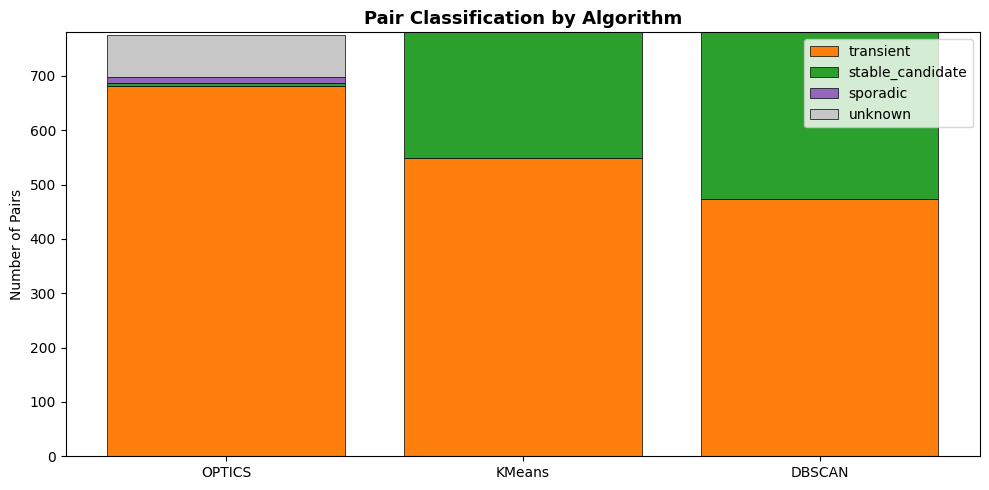

In [11]:
# Stacked bar chart of pair classification
cat_colors = {
    'transient': '#ff7f0e',
    'stable_candidate': '#2ca02c',
    'sporadic': '#9467bd',
    'unknown': '#c7c7c7',
}

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(available_algos))
bottoms = np.zeros(len(available_algos))

for cat in categories:
    vals = [cat_counts.get(a, {}).get(cat, 0) for a in available_algos]
    ax.bar(x, vals, bottom=bottoms, label=cat, color=cat_colors[cat],
           edgecolor='black', linewidth=0.5)
    bottoms += np.array(vals)

ax.set_xticks(x)
ax.set_xticklabels(available_algos)
ax.set_title('Pair Classification by Algorithm', fontweight='bold', fontsize=13)
ax.set_ylabel('Number of Pairs')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 6. Out-of-Sample Stability

In [12]:
# ==========================================================================
# SECTION 6: OOS Stability — Re-compute train/test correlation
# ==========================================================================
print('='*80)
print('OUT-OF-SAMPLE STABILITY')
print('='*80)

import itertools

def calc_pair_freq_from_history(history_df):
    freq = {}
    total = history_df['Datetime'].nunique()
    for ts in history_df['Datetime'].unique():
        snap = history_df[history_df['Datetime'] == ts]
        for cid in snap['Cluster_ID'].unique():
            if cid == -1:
                continue
            members = sorted(snap[snap['Cluster_ID'] == cid]['Ticker'].tolist())
            for s1, s2 in itertools.combinations(members, 2):
                freq[(s1, s2)] = freq.get((s1, s2), 0) + 1
    return {k: v / total for k, v in freq.items()}

oos_results = []
for algo in available_algos:
    ch = data[algo]['cluster_history']
    all_dates = sorted(ch['Datetime'].unique())
    split_point = int(len(all_dates) * 0.67)
    split_ts = all_dates[split_point]
    
    train_h = ch[ch['Datetime'] <= split_ts]
    test_h = ch[ch['Datetime'] > split_ts]
    
    train_freq = calc_pair_freq_from_history(train_h)
    test_freq = calc_pair_freq_from_history(test_h)
    
    common = set(train_freq.keys()) & set(test_freq.keys())
    if len(common) > 5:
        tv = [train_freq[p] for p in common]
        ev = [test_freq[p] for p in common]
        r, p = pearsonr(tv, ev)
    else:
        r, p = np.nan, np.nan
    
    oos_results.append({
        'Algorithm': algo,
        'Train Windows': train_h['Datetime'].nunique(),
        'Test Windows': test_h['Datetime'].nunique(),
        'Common Pairs': len(common),
        'OOS Correlation': r,
        'p-value': p,
    })
    print(f'{algo}: r={r:.3f} (p={p:.2e}), {len(common)} common pairs')

df_oos = pd.DataFrame(oos_results).set_index('Algorithm')
print()
print(df_oos.round(4).to_string())

OUT-OF-SAMPLE STABILITY


OPTICS: r=0.665 (p=1.02e-96), 747 common pairs


KMeans: r=0.735 (p=1.12e-133), 780 common pairs


DBSCAN: r=0.840 (p=7.59e-209), 780 common pairs

           Train Windows  Test Windows  Common Pairs  OOS Correlation  p-value
Algorithm                                                                     
OPTICS               914           450           747           0.6655      0.0
KMeans              1058           520           780           0.7355      0.0
DBSCAN              1058           520           780           0.8401      0.0


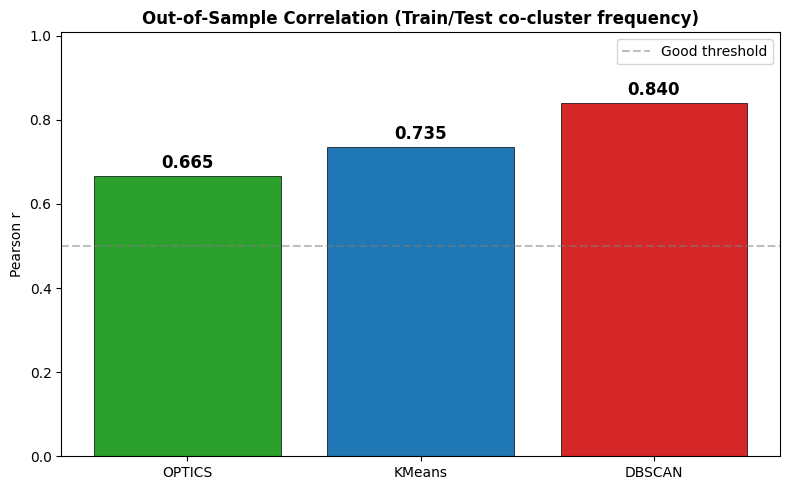

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
vals = [df_oos.loc[a, 'OOS Correlation'] for a in available_algos]
colors = [COLORS[a] for a in available_algos]
bars = ax.bar(available_algos, vals, color=colors, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.set_title('Out-of-Sample Correlation (Train/Test co-cluster frequency)',
             fontweight='bold', fontsize=12)
ax.set_ylabel('Pearson r')
ax.set_ylim(0, max(vals) * 1.2 if vals else 1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Good threshold')
ax.legend()
plt.tight_layout()
plt.show()

# 7. Grand Summary

In [14]:
# ==========================================================================
# SECTION 7: Grand Summary — Scorecard + Radar Chart
# ==========================================================================
print('='*80)
print('GRAND SUMMARY SCORECARD')
print('='*80)
print('(Structural metrics removed — only quality dimensions retained)')

# Build raw scorecard with only quality metrics
scorecard_raw = {}
for algo in available_algos:
    ch = data[algo]['cluster_history']
    fm = data[algo].get('df_formations', pd.DataFrame())
    fa = data[algo].get('df_formations_actionable', pd.DataFrame())
    dur = data[algo].get('df_durations', pd.DataFrame())
    pc = data[algo].get('pair_classification', pd.DataFrame())
    stab = data[algo].get('df_pair_stability', pd.DataFrame())
    
    clusters_per_ts = ch.groupby('Datetime').apply(
        lambda g: len(set(g['Cluster_ID'])) - (1 if -1 in g['Cluster_ID'].values else 0)
    )
    
    n_transient = len(pc[pc['Category'] == 'transient']) if len(pc) > 0 else 0
    oos_r = df_oos.loc[algo, 'OOS Correlation'] if algo in df_oos.index else 0
    
    scorecard_raw[algo] = {
        'Avg Clusters': clusters_per_ts.mean(),
        'Actionable Formations': len(fa),
        'Transient Pairs': n_transient,
        'OOS Correlation': oos_r,
    }

df_scorecard = pd.DataFrame(scorecard_raw).T
df_scorecard.index.name = 'Algorithm'

print('\nRaw Scores:')
print(df_scorecard.round(3).to_string())

# Rank-based scoring: rank 1 = best (highest value wins each dimension)
df_ranks = df_scorecard.rank(ascending=False, method='min')
df_ranks.columns = [f'{c} (Rank)' for c in df_ranks.columns]

print('\nRank-Based Scores (1 = best):')
print(df_ranks.round(0).astype(int).to_string())

# Compute average rank per algorithm
avg_ranks = df_ranks.mean(axis=1).sort_values()
print('\nAverage Rank (lower = better):')
for algo, avg in avg_ranks.items():
    print(f'  {algo}: {avg:.2f}')

# Normalize to [0, 1] for radar chart
df_norm = df_scorecard.copy()
for col in df_norm.columns:
    mn, mx = df_norm[col].min(), df_norm[col].max()
    if mx > mn:
        df_norm[col] = (df_norm[col] - mn) / (mx - mn)
    else:
        df_norm[col] = 1.0

print('\nNormalized Scores (0-1):')
print(df_norm.round(3).to_string())

GRAND SUMMARY SCORECARD
(Structural metrics removed — only quality dimensions retained)



Raw Scores:
           Avg Clusters  Actionable Formations  Transient Pairs  OOS Correlation
Algorithm                                                                       
OPTICS            3.359                20242.0            681.0            0.665
KMeans            3.093                18829.0            549.0            0.735
DBSCAN            1.470                17507.0            474.0            0.840



Rank-Based Scores (1 = best):
           Avg Clusters (Rank)  Actionable Formations (Rank)  Transient Pairs (Rank)  OOS Correlation (Rank)
Algorithm                                                                                                   
OPTICS                       1                             1                       1                       3
KMeans                       2                             2                       2                       2
DBSCAN                       3                             3                       3                       1

Average Rank (lower = better):
  OPTICS: 1.50
  KMeans: 2.00
  DBSCAN: 2.50

Normalized Scores (0-1):
           Avg Clusters  Actionable Formations  Transient Pairs  OOS Correlation
Algorithm                                                                       
OPTICS            1.000                  1.000            1.000            0.000
KMeans            0.859                  0.483            0.362            0.4

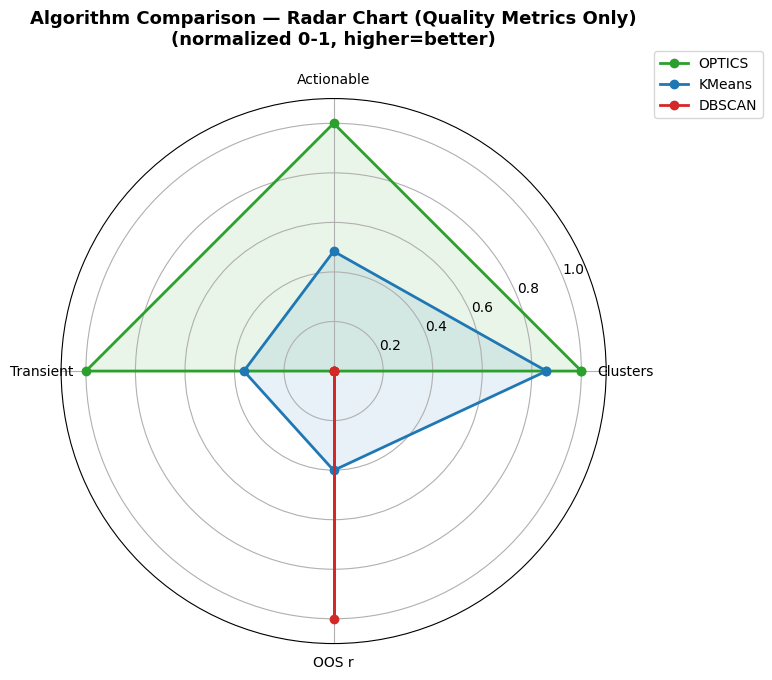

In [15]:
# Radar / Spider Chart
dimensions = list(df_norm.columns)
n_dims = len(dimensions)
angles = np.linspace(0, 2 * np.pi, n_dims, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for algo in available_algos:
    values = df_norm.loc[algo].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=algo, color=COLORS[algo])
    ax.fill(angles, values, alpha=0.1, color=COLORS[algo])

ax.set_xticks(angles[:-1])
short_labels = ['Clusters', 'Actionable', 'Transient', 'OOS r']
ax.set_xticklabels(short_labels, fontsize=10)
ax.set_ylim(0, 1.1)
ax.set_title('Algorithm Comparison — Radar Chart (Quality Metrics Only)\n(normalized 0-1, higher=better)',
             fontweight='bold', fontsize=13, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# 8. Recommendations

In [16]:
# ==========================================================================
# SECTION 8: Auto-Generated Recommendations
# ==========================================================================
print('='*80)
print('ALGORITHM RECOMMENDATIONS')
print('='*80)

# Determine winner per dimension (from raw scorecard — quality metrics only)
print('\nDimension Winners (quality metrics only):')
print('-' * 50)
winners = {}
for col in df_scorecard.columns:
    best_algo = df_scorecard[col].idxmax()
    best_val = df_scorecard[col].max()
    winners[col] = best_algo
    print(f'  {col:30s}: {best_algo} ({best_val:.3f})')

# Rank-based recommendation
print('\nRank-Based Summary:')
avg_ranks = df_ranks.mean(axis=1).sort_values()
for algo, avg in avg_ranks.items():
    print(f'  {algo}: avg rank = {avg:.2f}')

primary = avg_ranks.idxmin()
print(f'\nPrimary algorithm recommendation: {primary} (best average rank)')

# Consensus pairs
print(f'\n{"-"*50}')
print('CONSENSUS PAIRS (found in top-20 by ALL algorithms):')
if len(available_algos) >= 2:
    consensus = set.intersection(*[top_pairs[a] for a in available_algos])
    if consensus:
        for p in sorted(consensus):
            freqs = []
            for algo in available_algos:
                stab = data[algo]['df_pair_stability']
                match = stab[stab['Pair'] == p]
                f = match['Co_Cluster_Frequency'].values[0] if len(match) > 0 else 0
                freqs.append(f'{algo}={f:.3f}')
            print(f'  {p:20s} {"  ".join(freqs)}')
    else:
        print('  No consensus pairs found in top-20.')

# Trading recommendations
print(f'\n{"-"*50}')
print('TRADING STRATEGY RECOMMENDATIONS:')
print(f'  Primary signal:       Use {primary} for relationship detection')

# Pick confirmation algo (best OOS that isn't primary)
remaining = [a for a in available_algos if a != primary]
if remaining:
    confirm_scores = {a: df_oos.loc[a, 'OOS Correlation'] for a in remaining if a in df_oos.index}
    if confirm_scores:
        confirm_algo = max(confirm_scores, key=confirm_scores.get)
        print(f'  Confirmation signal:  Use {confirm_algo} to confirm (OOS r={confirm_scores[confirm_algo]:.3f})')

print(f'  Focus on:             Consensus pairs for highest confidence trades')
print(f'  Next step:            Run validation module on consensus pair formations')

print(f'\n{"="*80}')
print('COMPARISON COMPLETE')
print(f'{"="*80}')

ALGORITHM RECOMMENDATIONS

Dimension Winners (quality metrics only):
--------------------------------------------------
  Avg Clusters                  : OPTICS (3.359)
  Actionable Formations         : OPTICS (20242.000)
  Transient Pairs               : OPTICS (681.000)
  OOS Correlation               : DBSCAN (0.840)

Rank-Based Summary:
  OPTICS: avg rank = 1.50
  KMeans: avg rank = 2.00
  DBSCAN: avg rank = 2.50

Primary algorithm recommendation: OPTICS (best average rank)

--------------------------------------------------
CONSENSUS PAIRS (found in top-20 by ALL algorithms):
  ADI-NXPI             OPTICS=0.262  KMeans=0.801  DBSCAN=0.897
  ADI-SWKS             OPTICS=0.222  KMeans=0.794  DBSCAN=0.828
  ADI-TXN              OPTICS=0.257  KMeans=0.815  DBSCAN=0.815
  AMAT-KLAC            OPTICS=0.326  KMeans=0.771  DBSCAN=0.806
  AMAT-LRCX            OPTICS=0.361  KMeans=0.785  DBSCAN=0.841
  KLAC-LRCX            OPTICS=0.364  KMeans=0.774  DBSCAN=0.846
  NXPI-TXN             OPTIC